In [1]:
import os
import shap
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.stats import iqr
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

Matplotlib created a temporary cache directory at /JOBs/tmpdir/pbs.9670356.spcc-adm1/matplotlib-p2vi5ow_ because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2024-11-05 16:43:29.702528: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 16:43:29.705462: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 16:43:29.741004: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has alrea

In [2]:
class_labels = {
    0 : 'cat',
    1 : 'dog'
}
class_lables = list(class_labels.values())

In [4]:
def organize_by_class(expl_data, class_labels, model_names):
    return {
        class_name: [expl_data[class_name][model_name] for model_name in model_names] for class_name in class_labels
    }

def remove_outliers(scores):
    if len(scores) < 2:
        return scores
    scores_array = np.array(scores)
    q1, q3       = np.percentile(scores_array, [25, 75])
    iqr_value    = iqr(scores_array)
    lower_bound  = q1 - 1.5 * iqr_value
    upper_bound  = q3 + 1.5 * iqr_value
    
    return [score for score in scores_array if lower_bound <= score <= upper_bound]

In [5]:
def compute_cosine_distance_lime(mask1, mask2):
    if mask1.dtype != np.float32:
        mask1       = np.array(mask1).astype('float32')
    if mask2.dtype != np.float32:
        mask2       = np.array(mask2).astype('float32')

    mask1_flat      = mask1.flatten()
    mask2_flat      = mask2.flatten()

    dot_product     = np.dot(mask1_flat, mask2_flat)
    magnitude1      = np.linalg.norm(mask1_flat)
    magnitude2      = np.linalg.norm(mask2_flat)

    if magnitude1 == 0 or magnitude2 == 0:
        return 1.0
        # raise ValueError("One of both of the input masks have zero magnitude, causing division by zero.")
        
    similarity      = dot_product / (magnitude1 * magnitude2)
    cosine_distance = 1 - similarity

    return cosine_distance

def compute_mean_distance_lime(expl_list, model_names):
    pairwise_codistance  = {}
    
    for (i, expl_list1), (j, expl_list2) in itertools.combinations(enumerate(expl_list), 2):
        cosine_distances = []
    
        for expl1, expl2 in zip(expl_list1, expl_list2):
            distance     = compute_cosine_distance_lime(expl1, expl2) # >>>>>
            cosine_distances.append(distance)

        cleaned_distance = remove_outliers(cosine_distances)
        mean_distance    = np.mean(cleaned_distance)
        
        model_pair       = (model_names[i], model_names[j])
        pairwise_codistance[model_pair] = mean_distance

    return pairwise_codistance

In [ ]:
def apply_threshold_and_binarize(shap_values, percentile=0.2):

    shap_values_squeezed      = shap_values.squeeze()
    shap_values_float         = shap_values_squeezed.astype('float32')

    binarized_values          = np.zeros_like(shap_values_float)

    for channel in range(shap_values_float.shape[2]):  # Iterate through RGB channels
        shap_values_channel   = shap_values_float[:, :, channel]
        positive_shap_values  = shap_values_channel[shap_values_channel > 0]

        if positive_shap_values.size > 0:
            max_score         = np.max(positive_shap_values)
            threshold         = percentile * max_score
        else:
            max_score         = 0
            threshold         = 0
            print(f'No positive SHAP values found in channel {channel}')
        
        # print(f'Max Positive SHAP Score for Channel {channel} : {max_score:.4f}')
        # print(f'Threshold Value for Channel {channel}         : {threshold:.4f}')

        binarized_values[:, :, channel] = np.where(shap_values_channel >= threshold, 1, 0).astype('float32')

    grayscale_image = np.mean(binarized_values, axis=2) 

    return grayscale_image

def compute_cosine_distance_shap(mask1, mask2):
    mask1_values    = mask1[0].values
    mask2_values    = mask2[0].values

    mask1_binarized = apply_threshold_and_binarize(mask1_values)
    mask2_binarized = apply_threshold_and_binarize(mask2_values)
    
    mask1_flat      = mask1_binarized.flatten()
    mask2_flat      = mask2_binarized.flatten()

    dot_product     = np.dot(mask1_flat, mask2_flat)
    magnitude1      = np.linalg.norm(mask1_flat)
    magnitude2      = np.linalg.norm(mask2_flat)
    
    similarity      = dot_product / (magnitude1 * magnitude2)
    cosine_distance = 1 - similarity
    
    return cosine_distance

def compute_mean_distance_shap(expl_list, model_names):
    pairwise_codistance   = {}
    
    for (i, expl_list1), (j, expl_list2) in itertools.combinations(enumerate(expl_list), 2):
        cosine_distances  = []
     
        for expl1, expl2 in zip(expl_list1, expl_list2):
            cosine_dist   = compute_cosine_distance_shap(expl1, expl2)
            cosine_distances.append(cosine_dist)

        cleaned_distance  = remove_outliers(cosine_distances)
        mean_distance     = np.mean(cleaned_distance)
        
        model_pair        = (model_names[i], model_names[j])
        pairwise_codistance[model_pair] = mean_distance

    return pairwise_codistance

In [ ]:
# Plot class wise results in box-plot format
def plot_class_wise_cosine_distances(class_labels, model_names, class_wise_cosine, title):
    plt.figure(figsize=(20, 16))
    
    for i, class_name in enumerate(class_labels):
        # Prepare data for boxplot
        data = {
            f'{model_i} vs {model_j}': class_wise_cosine[class_name][(model_i, model_j)]
            for (model_i, model_j) in itertools.combinations(model_names, 2)
        }
        
        df = pd.DataFrame(data)

        # Create subplot for each class
        plt.subplot(1,2, i + 1)
        sns.boxplot(data = df, palette = 'Pastel1')
        plt.xlabel('Model Pair', fontsize  = 14)
        plt.xticks(rotation = 45, fontsize = 12)
        plt.ylabel('Cosine Distance Score', fontsize = 14)
        plt.yticks(fontsize=12)
        plt.title(f'{title}: {class_name}', fontsize = 14)
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [17]:
class_names  = class_labels.values()
model_extrcs = ["Xception", "InceptionV3", "DenseNet121", "ResNet50V2"]

In [18]:
for class_name in class_names:
    print(class_name)

cat
dog


In [21]:
temp_extrcs  = {class_name: {} for class_name in class_names}
mask_extrcs  = {class_name: {} for class_name in class_names}

for class_name in class_names:
    for model_name in model_extrcs:
        file_path = f'LIME Expls/diff_extrcs/explain_{class_name}_{model_name}.pkl'

        with open(file_path, 'rb') as file:
            temp_extrc, mask_extrc, _ = pickle.load(file)

        temp_extrcs[class_name][model_name] = temp_extrc
        mask_extrcs[class_name][model_name] = mask_extrc

In [24]:
print(len(temp_extrcs["cat"]["Xception"]))
print(len(mask_extrcs["dog"]["Xception"]))

50
50


In [26]:
# organize by class
lime_by_class_extrcs           = organize_by_class(mask_extrcs, class_names, model_extrcs)

class_wise_cosine_lime_extrcs  = {class_name: {pair: [] for pair in itertools.combinations(model_extrcs, 2)} for class_name in class_names}

for class_name in class_names:
    img_masks         = [mask_extrcs[class_name][model_name] for model_name in model_extrcs]
    
    for img_mask in zip(*img_masks):
        for (model_i, model_j) in itertools.combinations(model_extrcs, 2):
            mask_i        = img_mask[model_extrcs.index(model_i)]
            mask_j        = img_mask[model_extrcs.index(model_j)]

            if np.linalg.norm(mask_i) == 0 or np.linalg.norm(mask_j) == 0:
                print(f'Empty mask found between {model_i} and {model_j} for classs {class_name}')
                
            co_distance   = compute_cosine_distance_lime(mask_i, mask_j) 
            class_wise_cosine_lime_extrcs[class_name][(model_i, model_j)].append(co_distance) 
            

distance_dict_lime_extrcs = {}
for name in class_names:
    distance_dict_lime_extrcs[name] = compute_mean_distance_lime(expl_list   = lime_by_class_extrcs[name],
                                                                 model_names = model_extrcs)

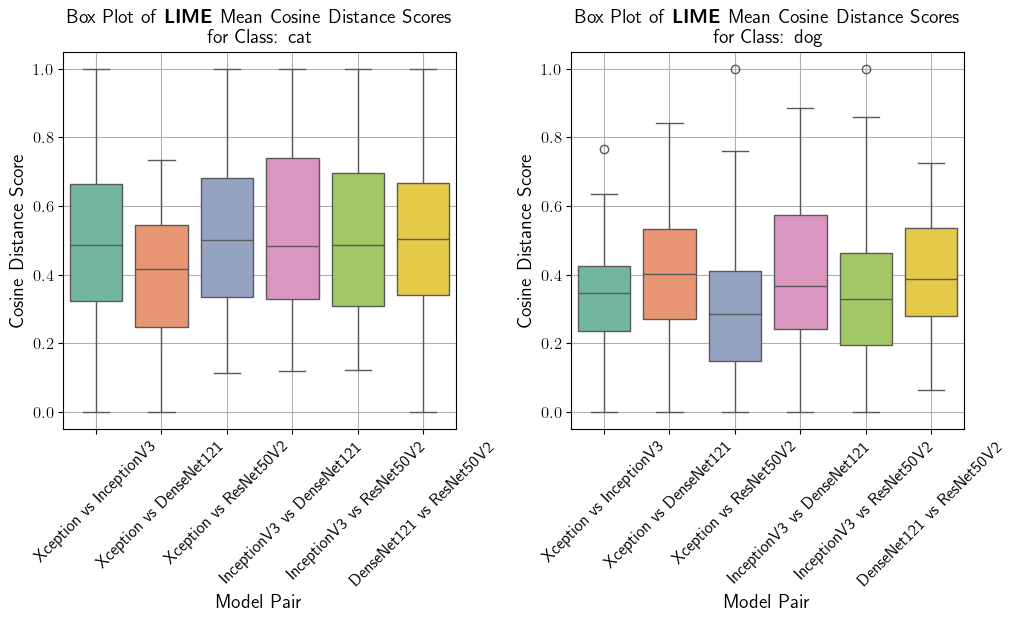

In [28]:
title = 'Box Plot of \\textbf{LIME} Mean Cosine Distance Scores\nfor Class'
plot_class_wise_cosine_distances(class_names, model_extrcs, class_wise_cosine_lime_extrcs, title)

In [37]:
shap_data_extrcs  = {class_name: {} for class_name in class_names}

for class_name in class_names:
    for i, model_name in enumerate(model_extrcs):
        file_path = f'SHAP Expls/diff_extrcs/explain_{class_name}_{model_name}_shap.pkl'
        
        with open(file_path, 'rb') as file:
            data  = pickle.load(file)

        shap_data_extrcs[class_name][model_name] = data

In [40]:
shap_by_class_extrcs          = organize_by_class(shap_data_extrcs, class_names, model_extrcs)

class_wise_cosine_shap_extrcs = {class_name: {pair: [] for pair in itertools.combinations(model_extrcs, 2)} for class_name in class_names}

for class_name in class_names:
    shap_values = [shap_data_extrcs[class_name][model_name] for model_name in model_extrcs] 
    
    for shap_value in zip(*shap_values):  # Pair the masks for each model for the same image
        for (model_i, model_j) in itertools.combinations(model_extrcs, 2):
            mask_i        = shap_value[model_extrcs.index(model_i)]
            mask_j        = shap_value[model_extrcs.index(model_j)]
            co_distance   = compute_cosine_distance_shap(mask_i, mask_j) 
            class_wise_cosine_shap_extrcs[class_name][(model_i, model_j)].append(co_distance) 

distance_dict_shap_extrcs = {}

for name in class_names:
    distance_dict_shap_extrcs[name]= compute_mean_distance_shap(expl_list = shap_by_class_extrcs[name], 
                                                              model_names = model_extrcs)

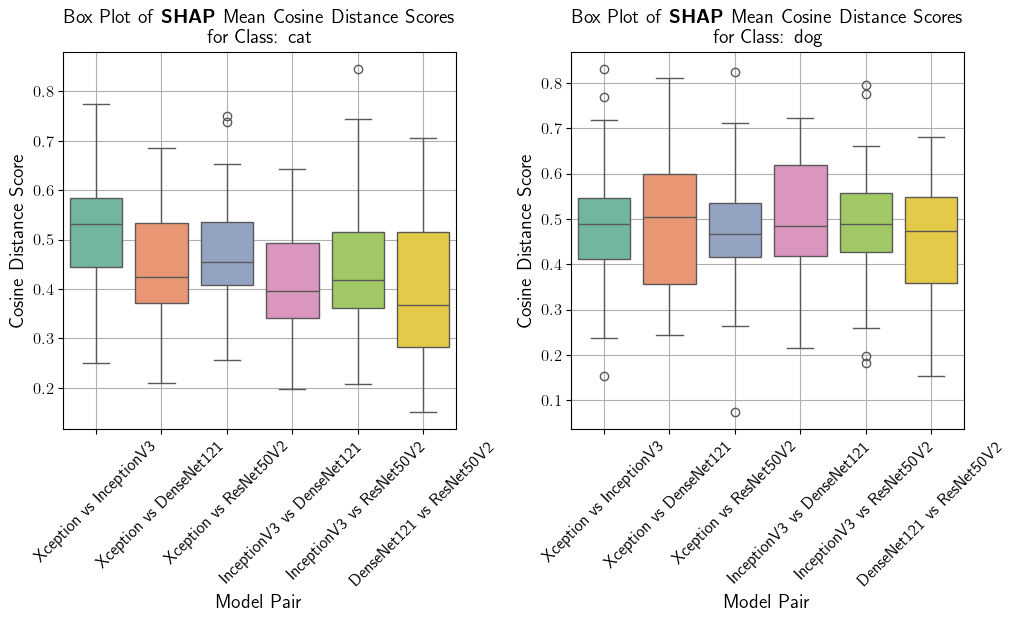

In [41]:
title = 'Box Plot of \\textbf{SHAP} Mean Cosine Distance Scores\n for Class'
plot_class_wise_cosine_distances(class_names, model_extrcs, class_wise_cosine_shap_extrcs, title)

In [42]:
model_opts = ["DenseNet-Adam", "DenseNet-Nadam", "DenseNet-RMSprop", "DenseNet-SGD"]

In [43]:
mask_opts = {class_name: {} for class_name in class_names}

for class_name in class_names:
    for model_opt in model_opts:
        file_path = f'LIME Expls/diff_opts/explain_{class_name}_{model_opt}.pkl'

        with open(file_path, 'rb') as file:
            _, mask_opt, _ = pickle.load(file)

        mask_opts[class_name][model_opt] = mask_opt

In [44]:
print(len(mask_opts['cat']['DenseNet-Adam']))

50


In [45]:
mask_by_class_opt          = organize_by_class(mask_opts, class_names, model_opts)

class_wise_cosine_lime_opt = {class_name: {pair: [] for pair in itertools.combinations(model_opts, 2)} for class_name in class_names}

for class_name in class_names:
    img_masks = [mask_opts[class_name][model_opt] for model_opt in model_opts]
    
    for img_mask in zip(*img_masks):
        for (opt_i, opt_j) in itertools.combinations(model_opts, 2):
            mask_i        = img_mask[model_opts.index(opt_i)]
            mask_j        = img_mask[model_opts.index(opt_j)]
            co_distance   = compute_cosine_distance_lime(mask_i, mask_j) 
            class_wise_cosine_lime_opt[class_name][(opt_i, opt_j)].append(co_distance)
            
distance_dict_lime_opts = {}

for name in class_names:
    distance_dict_lime_opts[name]= compute_mean_distance_lime(expl_list   = mask_by_class_opt[name], 
                                                              model_names = model_opts)

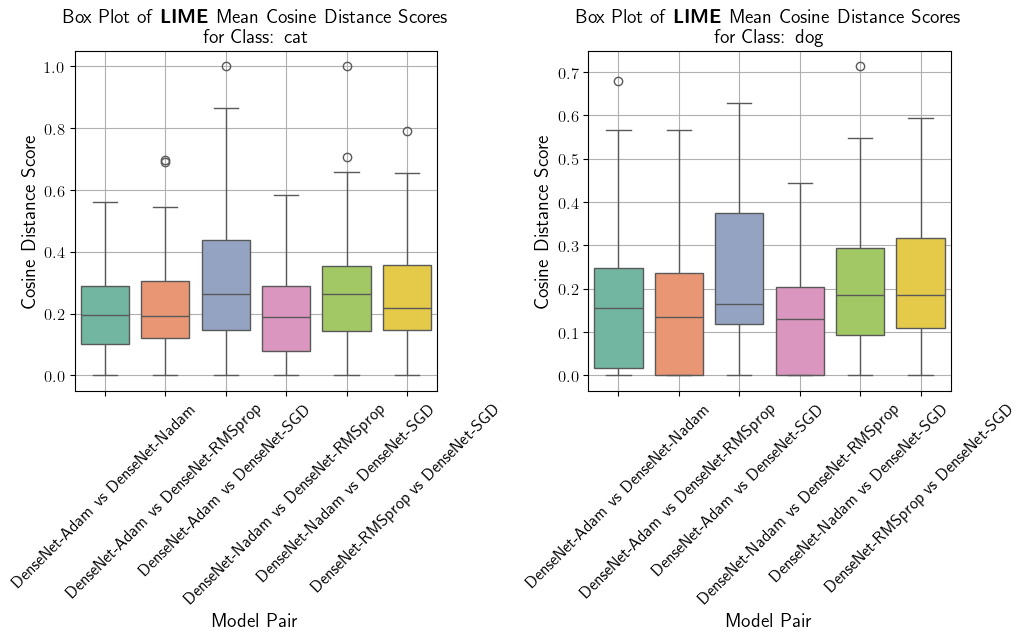

In [46]:
title = 'Box Plot of \\textbf{LIME} Mean Cosine Distance Scores\nfor Class'
plot_class_wise_cosine_distances(class_names, model_opts, class_wise_cosine_lime_opt, title)

In [47]:
shap_data_opts = {class_name: {} for class_name in class_names}

for class_name in class_names:
    for model_opt in model_opts:
        
        file_path = f'SHAP Expls/diff_opts/explain_{class_name}_{model_opt}_shap.pkl'

        with open(file_path, 'rb') as file:
            data = pickle.load(file)

        shap_data_opts[class_name][model_opt] = data

In [49]:
print(len(shap_data_opts['cat']['DenseNet-SGD']))
print(len(shap_data_opts['cat']['DenseNet-RMSprop']))

50
50


In [50]:
shap_by_class_opts          = organize_by_class(shap_data_opts, class_names, model_opts)

class_wise_cosine_shap_opts = {class_name: {pair: [] for pair in itertools.combinations(model_opts, 2)} for class_name in class_names}

for class_name in class_names:
    shap_values         = [shap_data_opts[class_name][model_opt] for model_opt in model_opts]
    
    for shap_value in zip(*shap_values):
        for (opt_i, opt_j) in itertools.combinations(model_opts, 2):
            mask_i      = shap_value[model_opts.index(opt_i)]
            mask_j      = shap_value[model_opts.index(opt_j)]
            co_distance = compute_cosine_distance_shap(mask_i, mask_j) 
            class_wise_cosine_shap_opts[class_name][(opt_i, opt_j)].append(co_distance) 

distance_dict_shap_opts  = {}

for name in class_names:
    distance_dict_shap_opts[name] = compute_mean_distance_shap(expl_list   = shap_by_class_opts[name],
                                                               model_names = model_opts)

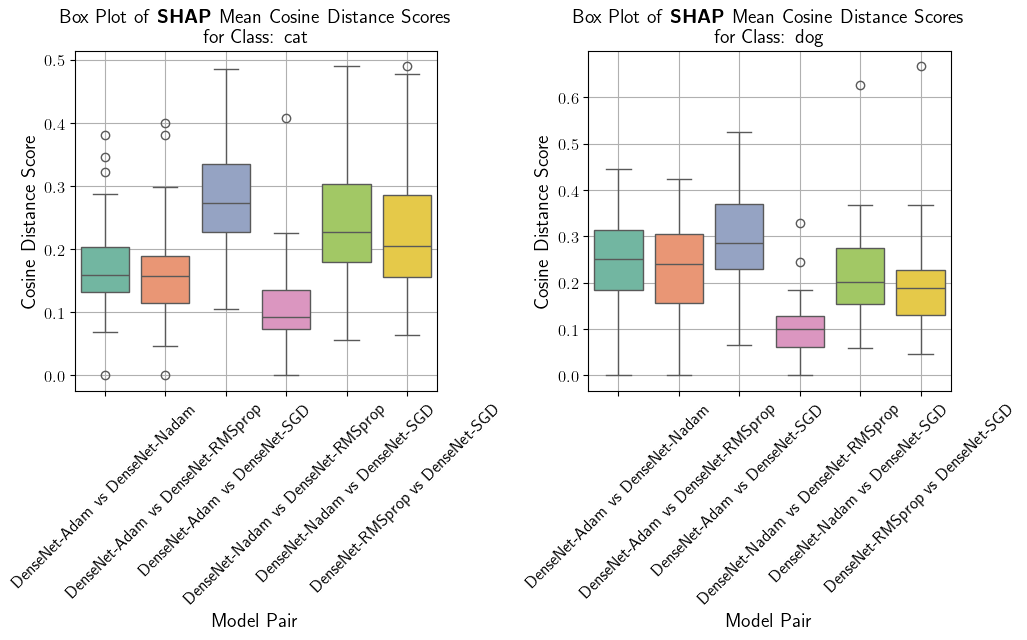

In [51]:
title = 'Box Plot of \\textbf{SHAP} Mean Cosine Distance Scores\nfor Class'
plot_class_wise_cosine_distances(class_names, model_opts, class_wise_cosine_shap_opts, title)

In [53]:
model_seeds = []

for i in range(10):
    seed = f'Dense{i+1}'
    model_seeds.append(seed)

for seed in model_seeds:
    print(seed)

Dense1
Dense2
Dense3
Dense4
Dense5
Dense6
Dense7
Dense8
Dense9
Dense10


In [56]:
mask_seeds      = {class_name: {} for class_name in class_names}

for class_name in class_names:
    for model_seed in model_seeds:
        
        file_path = f'LIME Expls/diff_seeds/explain_{class_name}_{model_seed}.pkl'

        with open(file_path, 'rb') as file:
            _, mask_seed, _       = pickle.load(file)
            
        mask_seeds[class_name][model_seed] = mask_seed

In [ ]:
# organize by class
mask_by_class_seeds          = organize_by_class(mask_seeds, class_names, model_seeds)

distance_dict_lime_seeds = {}

for name in class_names:
    distance_dict_lime_seeds[name] = compute_mean_distance_lime(expl_list   = mask_by_class_seeds[name],
                                                                model_names = model_seeds)


In [58]:
shap_data_seeds = {class_name: {} for class_name in class_names}

for class_name in class_names:
    for model_seed in model_seeds:
        
        file_path = f'SHAP Expls/diff_seeds/explain_{class_name}_{model_seed}_shap.pkl'

        with open(file_path, 'rb') as file:
            data = pickle.load(file)

        shap_data_seeds[class_name][model_seed] = data

In [ ]:
shap_by_class_seeds          = organize_by_class(shap_data_seeds, class_names, model_seeds)

distance_dict_shap_seeds     = {}
for name in class_names:
    distance_dict_shap_seeds[name] = compute_mean_distance_shap(expl_list   = shap_by_class_seeds[name],
                                                                model_names = model_seeds)

In [86]:
def extract_average_score(mean_cosine_scores, class_names=class_names):
    model_pair    = list(mean_cosine_scores['cat'])
    average_score = []
    
    for class_name in class_names:
        score     = np.mean([mean_cosine_scores[class_name][pair] for pair in model_pair])
        average_score.append(score)

    return average_score

In [92]:
avg_model_extrcs_lime   = extract_average_score(distance_dict_lime_extrcs)
avg_model_opts_lime     = extract_average_score(distance_dict_lime_opts)
avg_model_seeds_lime    = extract_average_score(distance_dict_lime_seeds)

data_lime = {
    'Class'            : class_names,
    'diff extractors'  : avg_model_extrcs_lime,
    'diff optimizers'  : avg_model_opts_lime,
    'diff seeds'       : avg_model_seeds_lime,
}

df_lime = pd.DataFrame(data_lime)
print(df_lime)

  Class  diff extractors  diff optimizers  diff seeds
0   cat         0.500842         0.229077    0.192264
1   dog         0.362047         0.184862    0.151459


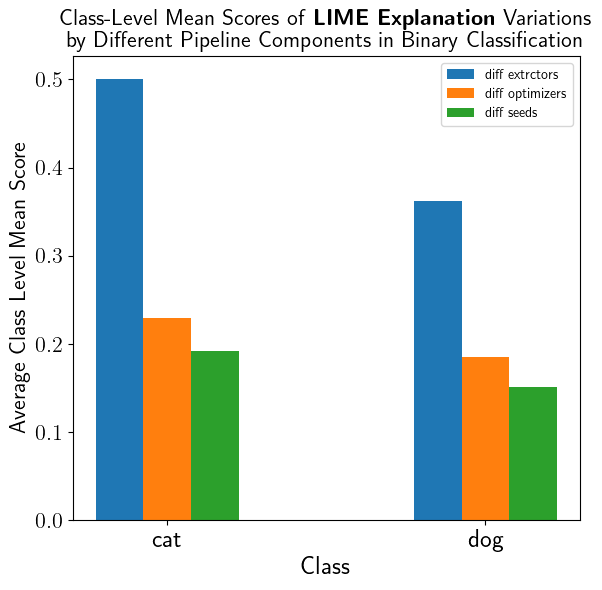

In [132]:
bar_width = 0.15
index     = np.arange(len(df_lime['Class']))

fig, ax   = plt.subplots(figsize=(6,6))

bar1      = ax.bar(index, df_lime['diff extractors'], bar_width, label = 'diff extrctors')
bar2      = ax.bar(index + bar_width, df_lime['diff optimizers'], bar_width, label = 'diff optimizers')
bar3      = ax.bar(index + 2 * bar_width, df_lime['diff seeds'], bar_width, label = 'diff seeds')

ax.set_xlabel('Class', fontsize=18)
ax.set_ylabel('Average Class Level Mean Score', fontsize=16)
ax.set_title("Class-Level Mean Scores of \\textbf{LIME Explanation} Variations\n"
             "by Different Pipeline Components in Binary Classification", 
             fontsize=16)
ax.set_xticks(index+bar_width)
ax.set_xticklabels(df_lime['Class'], fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.legend()

plt.tight_layout()
plt.show()

In [96]:
avg_model_extrcs_shap   = extract_average_score(distance_dict_shap_extrcs)
avg_model_opts_shap     = extract_average_score(distance_dict_shap_opts)
avg_model_seeds_shap    = extract_average_score(distance_dict_shap_seeds)

data_shap = {
    'Class'            : class_names,
    'diff extractors'  : avg_model_extrcs_shap,
    'diff optimizers'  : avg_model_opts_shap,
    'diff seeds'       : avg_model_seeds_shap,
}

df_shap = pd.DataFrame(data_shap)
print(df_shap)

  Class  diff extractors  diff optimizers  diff seeds
0   cat         0.446570         0.192597    0.146814
1   dog         0.481094         0.211253    0.140087


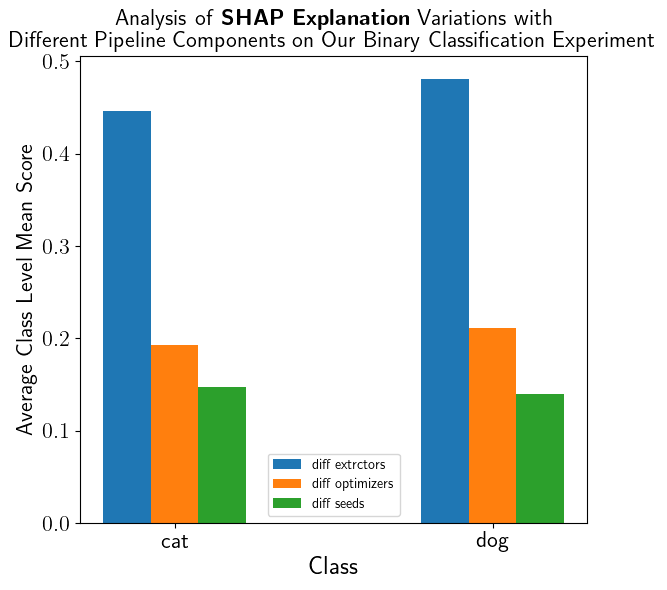

In [134]:
fig, ax   = plt.subplots(figsize=(6,6))

bar1      = ax.bar(index, df_shap['diff extractors'], bar_width, label = 'diff extrctors')
bar2      = ax.bar(index + bar_width, df_shap['diff optimizers'], bar_width, label = 'diff optimizers')
bar3      = ax.bar(index + 2 * bar_width, df_shap['diff seeds'], bar_width, label = 'diff seeds')


ax.set_xlabel('Class', fontsize=18)
ax.set_ylabel('Average Class Level Mean Score', fontsize=16)
ax.set_title('Analysis of \\textbf{SHAP Explanation} Variations with\nDifferent Pipeline Components on Our Binary Classification Experiment', fontsize=16)
ax.set_xticks(index+bar_width)
ax.set_xticklabels(df_shap['Class'], fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend()

plt.tight_layout()
plt.show()